Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [4]:
## Using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Data Reading

In [7]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Dataset Creation

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write the train dataset
## use seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## resize the images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write the validation dataset
## seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## resize your images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             validation_split=0.2,
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization 
#### code to visualize one instance of all the nine classes present in the dataset

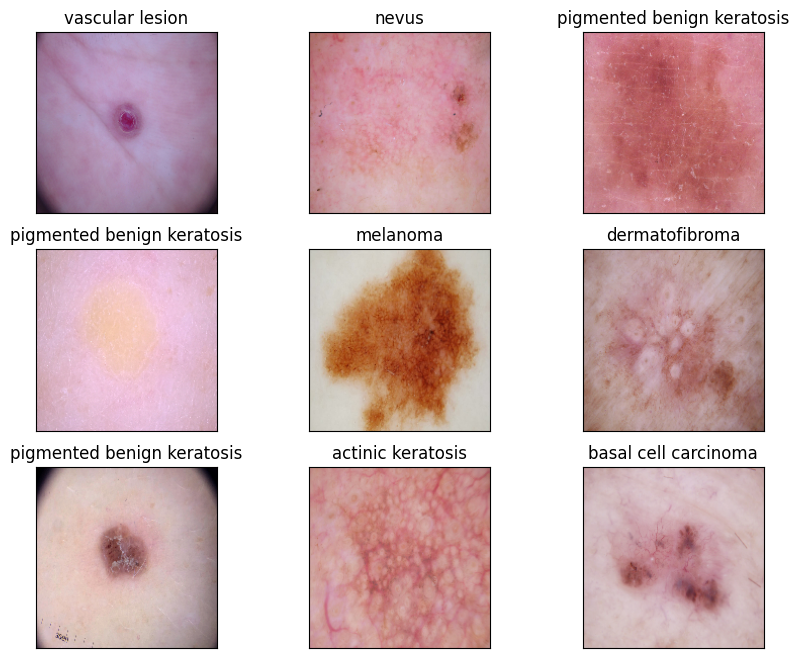

In [13]:
### use training or validation data to visualize

num_classes = 9
plt.figure(figsize=[10,8])
for img,labl in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, 1 + i, xticks=[], yticks=[])
        plt.title(class_names[labl[i]])
        plt.imshow(img[i].numpy().astype('uint8'))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building and Training

### Creating the first model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### code for first model
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))])

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 230s 918ms/step - loss: 2.0762 - accuracy: 0.2215 - val_loss: 1.9377 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7719 - accuracy: 0.3544 - val_loss: 1.6316 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5843 - accuracy: 0.4475 - val_loss: 1.4842 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3840 - accuracy: 0.5184 - val_loss: 1.3635 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3131 - accuracy: 0.5368 - val_loss: 1.3622 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1963 - accuracy: 0.5798 - val_loss: 1.3563 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1142 - accuracy: 0.6010 - val_loss: 1.3939 - val_accuracy: 0.5213
Epoch 8/20

### Visualizing training results

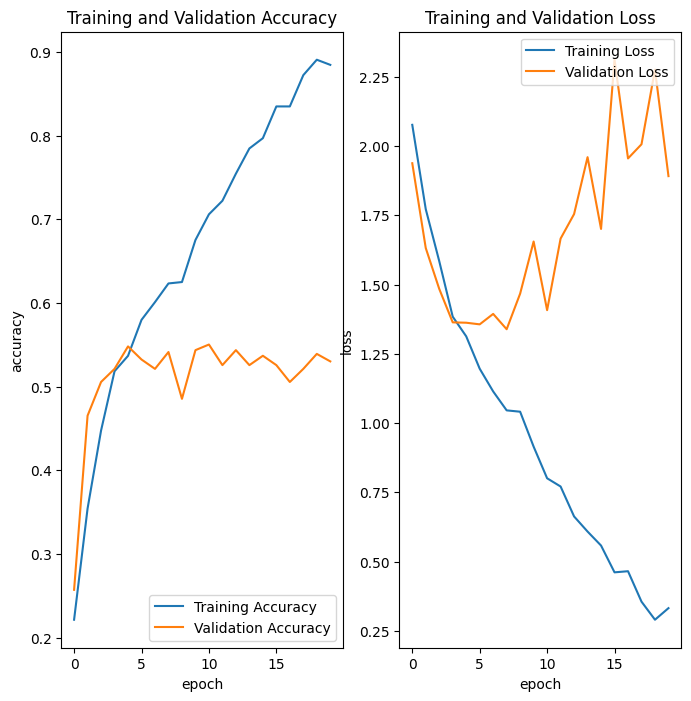

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()

### Findings of First Model

It can be clearly observed from the aforementioned graphs that the training accuracy is very high than the validation accuracy. Also, there is a much difference between the two loss functions at the last two epochs of the model. Therefore, this model is a case of an **Overfitting** model.

- **Training Accuracy: 88.45**
- **Validation Accuracy: 53.02**

## Data Augmentation

In [20]:
# Data augumentation strategy

data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape = (img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

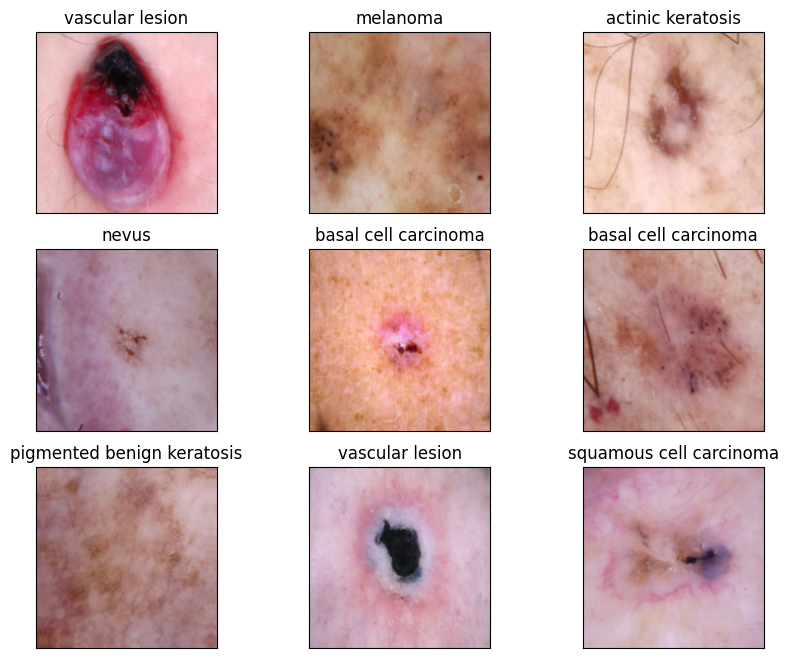

In [21]:
# Visualizing the working of augmentation strategy for one instance of training image.

plt.figure(figsize=[10,8])
for img,labl in train_ds.take(1):
    for i in range(num_classes):
        augmented_img = data_augmentation(img)
        ax = plt.subplot(3, 3, 1 + i, xticks=[], yticks=[])
        plt.title(class_names[labl[i]])
        plt.imshow(augmented_img[i].numpy().astype('uint8'))

## Model Building and Training

### Create the Second model

In [22]:
## Using Dropout layer as there is an evidence of overfitting in the findings

model_2 = Sequential([data_augmentation,
                      layers.experimental.preprocessing.Rescaling(1./255),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Dropout(0.2),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),
                      layers.Dense(num_classes)])

### Compiling the model

In [23]:
## Compiling model_2
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_2 summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## train model for 20 epochs

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 36ms/step - loss: 2.0809 - accuracy: 0.2026 - val_loss: 2.0114 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.9109 - accuracy: 0.2796 - val_loss: 1.6922 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5723 - accuracy: 0.4453 - val_loss: 1.4874 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4186 - accuracy: 0.5073 - val_loss: 1.4229 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3655 - accuracy: 0.5246 - val_loss: 1.4503 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3089 - accuracy: 0.5480 - val_loss: 1.3616 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.2666 - accuracy: 0.5525 - val_loss: 1.3825 - val_accuracy: 0.5638
Epoch 8/20
56

### Visualizing the results

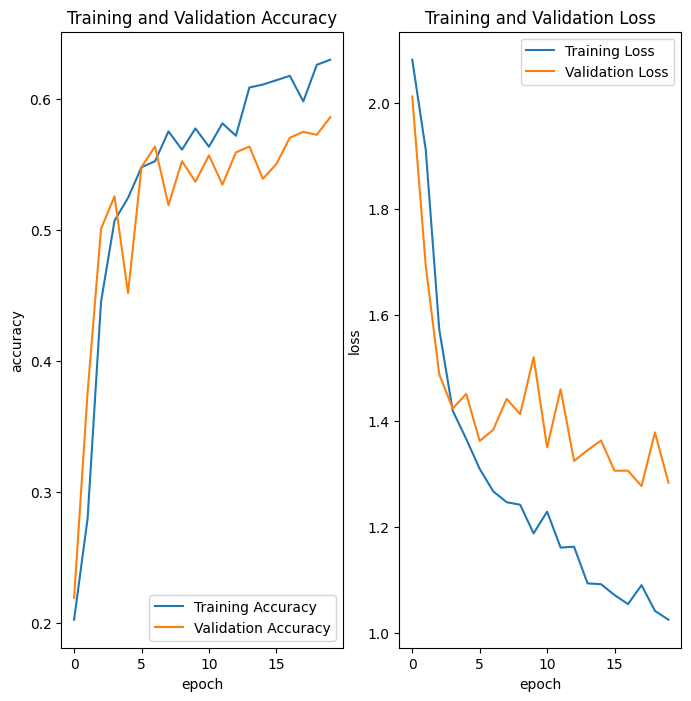

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()

### Findings of Second Model

The gap between the training accuracy and validation accuracy has reduced although the training accuracy has decreased as compared to the base model. The gap between the two losses has also been reduced. Therefore the overfitting issue has been reduced after data augmentation.

- **Training Accuracy: 63.0**
- **Validation Accuracy: 58.61**

## Class Distribution 
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

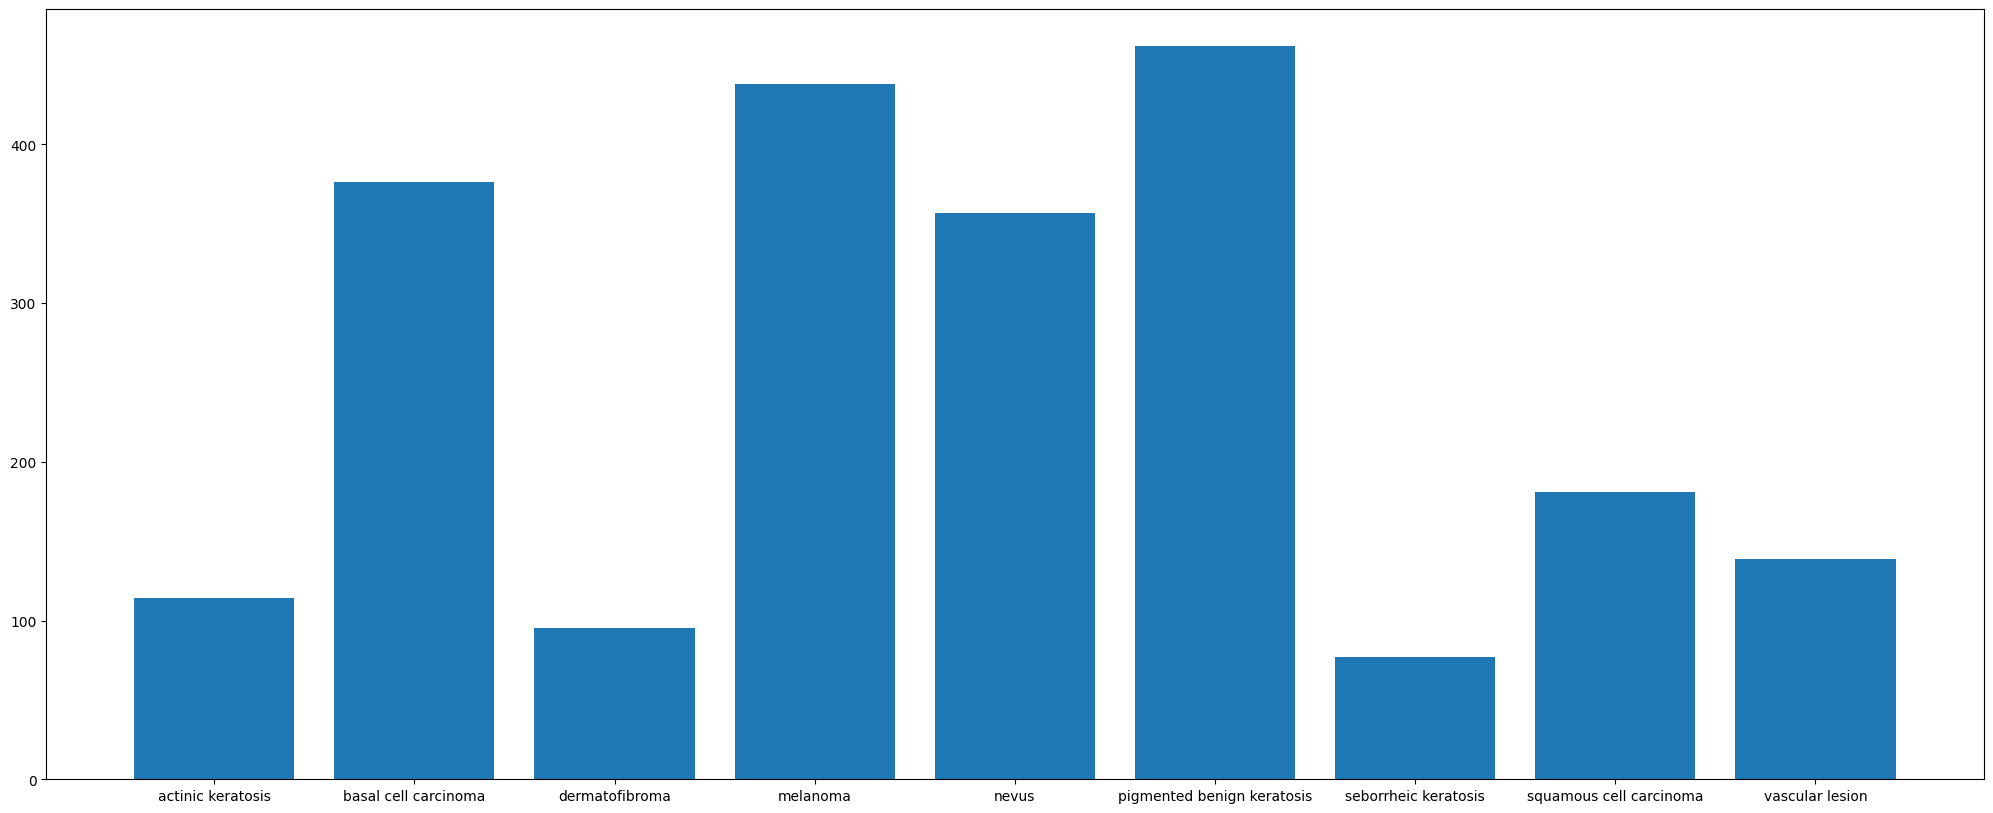

In [26]:
## plotting count of images in each class in the training dataset

count=[]
for n in class_names:
    count.append(len(list(data_dir_train.glob(n+'*/*.jpg'))))
plt.figure(figsize=[25,10])
plt.bar(class_names,count)
plt.show()

###  Findings from the aforementioned plot:
The aforementioned plot shows a significant class imbalance among all the nine classes of the training data.

#### - Which class has the least number of samples?
 - ***Seborrrheic Keratosis*** has least no. of samples.
  
#### - Which classes dominate the data in terms proportionate number of samples?
- ***Pigmented Benign Keratosis*** dominate in terms of proportionate no. of samples.

## Handling the class imbalance
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset = str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3070343040>: 100%|██████████| 500/500 [00:28<00:00, 17.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F30705152A0>: 100%|██████████| 500/500 [00:30<00:00, 16.53 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F312C5BC700>: 100%|██████████| 500/500 [00:23<00:00, 21.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F309637A830>: 100%|██████████| 500/500 [02:09<00:00,  3.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F307173BBE0>: 100%|██████████| 500/500 [01:43<00:00,  4.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F307173BE80>: 100%|██████████| 500/500 [00:24<00:00, 20.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F30756EB2E0>: 100%|██████████| 500/500 [00:57<00:00,  8.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F309637B7F0>: 100%|██████████| 500/500 [00:23<00:00, 21.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F307566C220>: 100%|██████████| 500/500 [00:25<00:00, 19.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Distribution of augmented data after adding new images to the original training data.

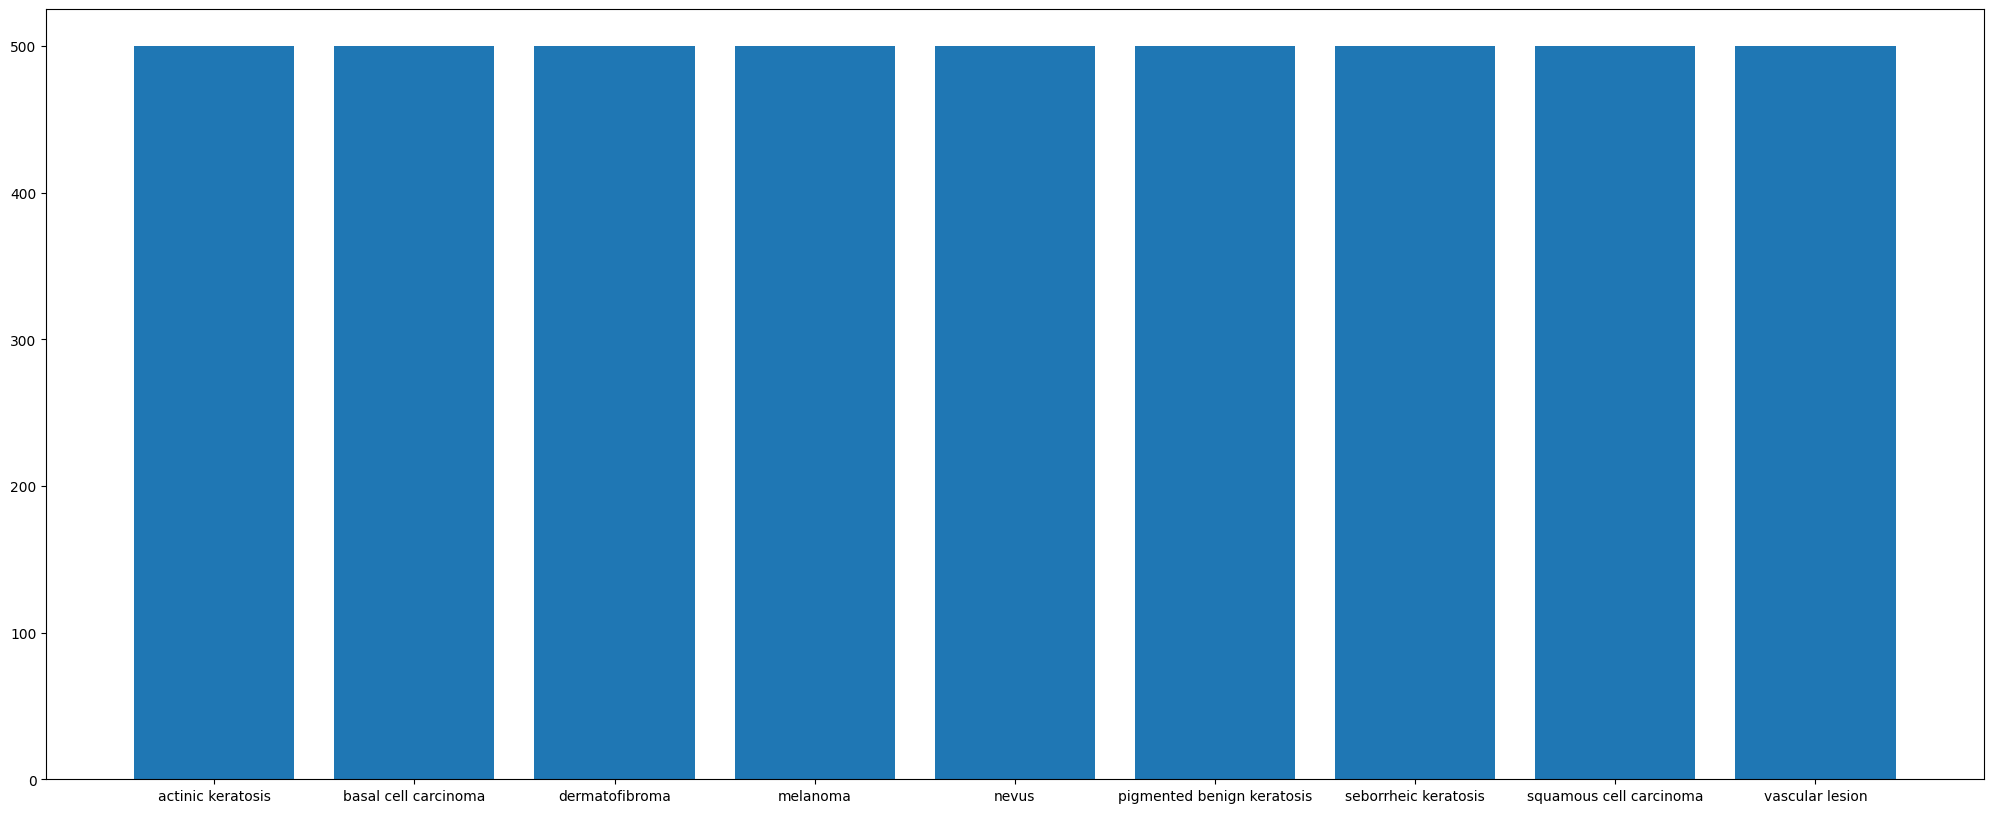

In [30]:
## distribution of classes in the training dataset

count=[]
for n in class_names:
    count.append(len(list(data_dir_train.glob(n+'*/output/*.jpg'))))
plt.figure(figsize=[25,10])
plt.bar(class_names,count)
plt.show()

In [31]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_ea0ed8fe-8456-496b-b1f7-c5ca2c2c3a84.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_bf9cdc92-aecb-47fd-abed-bfe6dbf629cf.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_afb24d41-546a-4d02-b610-2b5670b11147.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_196be6ab-7b74-4841-8310-34d565edc925.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_bb223726

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
# getting existing images in the Dataframe
path_list=[]
lesion_list=[]
for n in class_names:
    for f in data_dir_train.glob(n+'/*.jpg'):
        path_list.append(str(f))
        lesion_list.append(n)

df_dict_original = dict(zip(path_list,lesion_list))
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path', 'Label'])

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-35-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model Building and Training
### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training' ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the Third model (including normalization)

In [41]:
## creating third model

model_3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Dropout(0.2),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),
                      layers.Dense(num_classes)])

### Compiling the model

In [43]:
## compiling the model_3
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [44]:
epochs = 30
## training model_3 using 30 epochs.
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 87ms/step - loss: 1.9107 - accuracy: 0.2647 - val_loss: 1.6225 - val_accuracy: 0.3727
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.4442 - accuracy: 0.4527 - val_loss: 1.3281 - val_accuracy: 0.5026
Epoch 3/30
169/169 [==============================] - 5s 30ms/step - loss: 1.2162 - accuracy: 0.5484 - val_loss: 1.2087 - val_accuracy: 0.5516
Epoch 4/30
169/169 [==============================] - 5s 27ms/step - loss: 1.0879 - accuracy: 0.6105 - val_loss: 1.0443 - val_accuracy: 0.6162
Epoch 5/30
169/169 [==============================] - 5s 30ms/step - loss: 0.9216 - accuracy: 0.6667 - val_loss: 0.9665 - val_accuracy: 0.6422
Epoch 6/30
169/169 [==============================] - 5s 30ms/step - loss: 0.7643 - accuracy: 0.7235 - val_loss: 1.0831 - val_accuracy: 0.6281
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.6767 - accuracy: 0.7515 - val_loss: 0.8155 - val_accuracy: 0.732

###  Visualize the model results

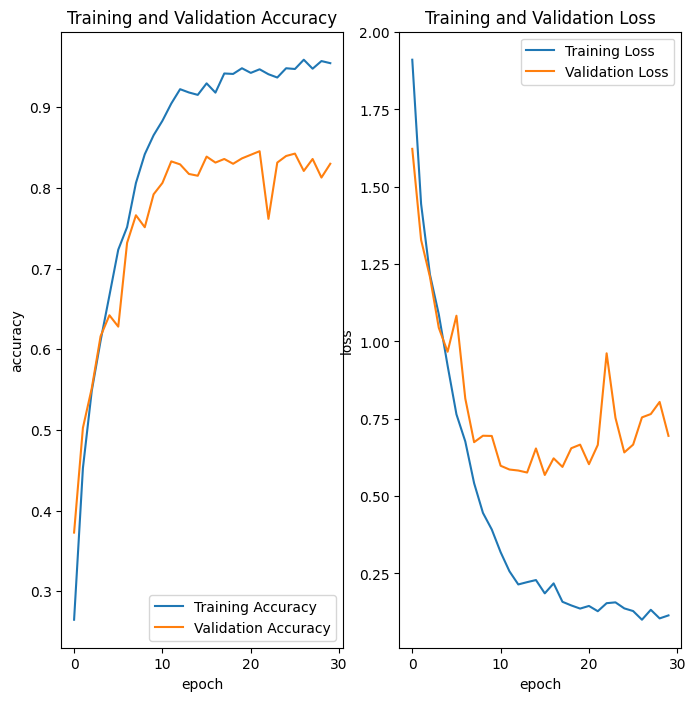

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()

### Analyzing the results of third model. 

The class rebalance and augmentation have really helped as it can be clearly observed from the aforementioned plot that both the accuracies have significantly increased and there is no more overfitting.

- **Training Accuracy: 95.47**
- **Validation Accuracy: 83.0**